<a href="https://colab.research.google.com/github/RGologorsky/fastproj/blob/master/Image_Segmentation_Hair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: label pixels with hair

## Imports

In [0]:
%matplotlib inline

In [0]:
%%capture
!pip install fastai2

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pathlib import Path

In [0]:
from google.colab import drive

In [0]:
# utils
def pp_list(l): print(f"len {len(l)}:", *l, sep="\n")

In [53]:
pp_list(range(2))

len 2:
0
1


## Unzip Data

In [0]:
drive.mount('/content/drive')

In [0]:
base_path = Path("drive/My Drive/fastai_proj")

In [0]:
proj = "segmentation"
proj_path = base_path/proj
pp_list(proj_path.ls())

In [0]:
data_src = proj_path/"face_segment_data_sampleset.zip"
data_dest = proj_path/"data"

In [0]:
# !unzip -qq "$data_src" -d "$data_dest"

## View data w/labels

In [0]:
path_lbl = data_dest/"labels"
path_img = data_dest

In [144]:
lbl_names = get_image_files(path_lbl)
pp_list(lbl_names[:3])

len 3:
drive/My Drive/fastai_proj/segmentation/data/labels/femalefelice/headrende0000.png
drive/My Drive/fastai_proj/segmentation/data/labels/femalefelice/headrende0020.png
drive/My Drive/fastai_proj/segmentation/data/labels/femalefelice/headrende0040.png


In [0]:
# look for images in all folders except for "labels"
def rm_path_prefix(f, prefix=path_img): return str(f).replace(f"{prefix}/", "")
img_folders = [rm_path_prefix(p) for p in path_img.ls() if p != path_lbl]

# def rm_parent_path(f): return re.search("(?!.*\/).*", str(f)).group(0)

In [159]:
fnames = get_image_files(data_dest, recurse=True, folders=img_folders)
pp_list(fnames[:3])

len 3:
drive/My Drive/fastai_proj/segmentation/data/femalefelice_env04/headrende0000.png
drive/My Drive/fastai_proj/segmentation/data/femalefelice_env04/headrende0020.png
drive/My Drive/fastai_proj/segmentation/data/femalefelice_env04/headrende0040.png


# Associate fname to label

In [0]:
path_lbl = data_dest/"labels"

In [54]:
fnames = get_image_files(data_dest, recurse=True)
pp_list(fnames[:3])

len 3:
drive/My Drive/fastai_proj/segmentation/data/femalefelice_env04/headrende0000.png
drive/My Drive/fastai_proj/segmentation/data/femalefelice_env04/headrende0020.png
drive/My Drive/fastai_proj/segmentation/data/femalefelice_env04/headrende0040.png


In [0]:
lbl_names = get_image_files()

## View image/label mask

In [117]:
data_dest

Path('drive/My Drive/fastai_proj/segmentation/data')

In [0]:
def rm_underscore(x): return re.search(".*(?=_)", str(x)).group(0)
get_y_fn = lambda x: path_lbl/rm_underscore(rm_path_prefix(x))/x.name

In [183]:
# a = rm_path_prefix(fnames[0])
# print(a)
# b = rm_underscore(a)
# print(b)
get_y_fn(fnames[0]) == lbl_names[0]
pp_list([fnames[0], get_y_fn(fnames[0]), lbl_names[0]])

len 3:
drive/My Drive/fastai_proj/segmentation/data/femalefelice_env04/headrende0000.png
drive/My Drive/fastai_proj/segmentation/data/labels/femalefelice/headrende0000.png
drive/My Drive/fastai_proj/segmentation/data/labels/femalefelice/headrende0000.png


In [0]:
idx = -1
fname = path_img/"maleandrew2_env01/headrende0240.png"


In [0]:
# training image
img_f = fnames[idx] if idx != -1 else fname
img = PILImage.create(img_f)
#img.show()

In [0]:
# labeled image
img_lbl_f = get_y_fn(img_f)
img_lbl = PILImage.create(img_lbl_f)
# img_lbl.show()

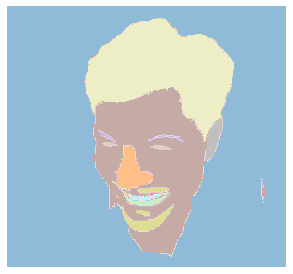

In [317]:
# masked image
mask = PILMask.create(img_lbl_f)
mask.show()

In [318]:
tensor(mask), mask.shape

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8), (280, 300))

In [319]:
unique_vals = np.unique(mask)
unique_vals, len(unique_vals), len(codes)

(array([  0,  29,  76, 105, 128, 150, 179, 211, 226, 255], dtype=uint8),
 10,
 10)

In [0]:
orig_mask = mask
orig_img = img_f

In [0]:
mask_arr = np.array(orig_mask)
img_arr = np.array(Image.open(img_f))

In [322]:
mask_arr.shape, img_arr.shape

((280, 300), (280, 300, 3))

In [323]:
unique_vals

array([  0,  29,  76, 105, 128, 150, 179, 211, 226, 255], dtype=uint8)

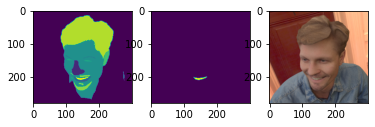

In [338]:
val = 255
mask_arr = np.array(orig_mask)
mask_arr[mask_arr != val] = 0
mask_arr[mask_arr == val] = 255
new_mask = Image.fromarray(mask_arr)
new_mask

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(mask)
ax2.imshow(new_mask)
ax3.imshow(img)
plt.show()

In [0]:
segm_codes = {
    0: "NA",
    29: "nose",
    76: "mouth",
    105: "eyebrow",
    128: "skin",
    150: "eye",
    179: "ear",
    211: "below-nose-moustaches",
    226: "hair",
    255: "teeth",
}

In [0]:
# plot training, label, & mask
img_l = PILImage.create(get_y_fn(f))

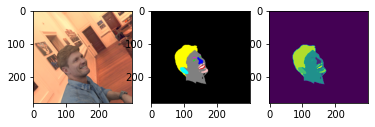

In [243]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img)
ax2.imshow(img_lbl)
ax3.imshow(mask)
plt.show()

In [244]:
src_size = np.array(mask.shape[1:])
src_size, tensor(mask)

(array([300]), tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8))

In [0]:
codes = np.array(["eyes","nose","ears","mouth","teeth","hair","eyebrows","beard", "mousetach", "NA"])

In [249]:
unique_vals = np.unique(mask)
unique_vals, len(unique_vals), len(codes)

(array([  0,  29,  76, 105, 128, 150, 179, 211, 226, 255], dtype=uint8),
 10,
 10)

In [222]:
mask.shape

(280, 300)

In [223]:
img.shape

(280, 300)